# Centróides Brasil  

### *Dados padronizados

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/centroides_brasil.ipynb`

## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree, dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

/home/walef/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/walef/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


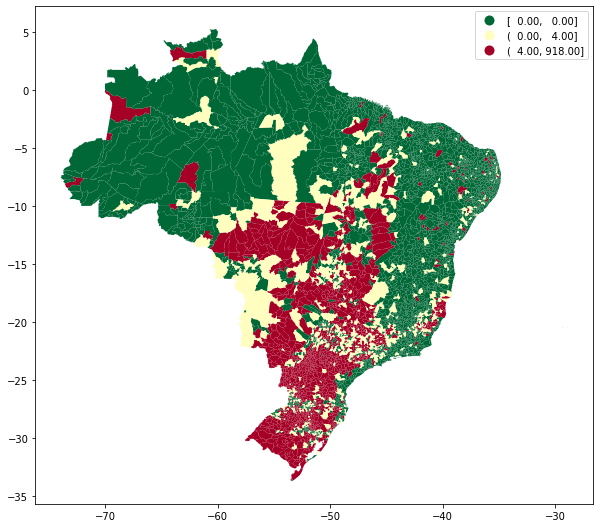

In [21]:
dados_br.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', cmap='RdYlGn_r', legend=True, k=4);
#dados_br.plot(column='nome_meso', figsize=(10, 10), cmap='RdYlGn_r'); # , cmap='OrRd',  cmap='plasma'

## Centroides




In [22]:
dados_br.geometry.centroid.x

dados_br['x_centroid'] = dados_br.geometry.centroid.x
dados_br['y_centroid'] = dados_br.geometry.centroid.y

/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [23]:
dados_centroids = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # 
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides

In [24]:
# subselecionar variáveis
XX = scale(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))# transformar em matriz (necessário para gerar o gráfico)
# mudar o tipo dos dados
X = np.asarray(XX, dtype=float)
n = X.shape[0]
p = X.shape[1]
# vetor de médias
Xb = np.mean(X, axis=0)
# matriz de covariâncias
S = np.cov(X.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [25]:
Z = linkage(X, method='ward')

In [26]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

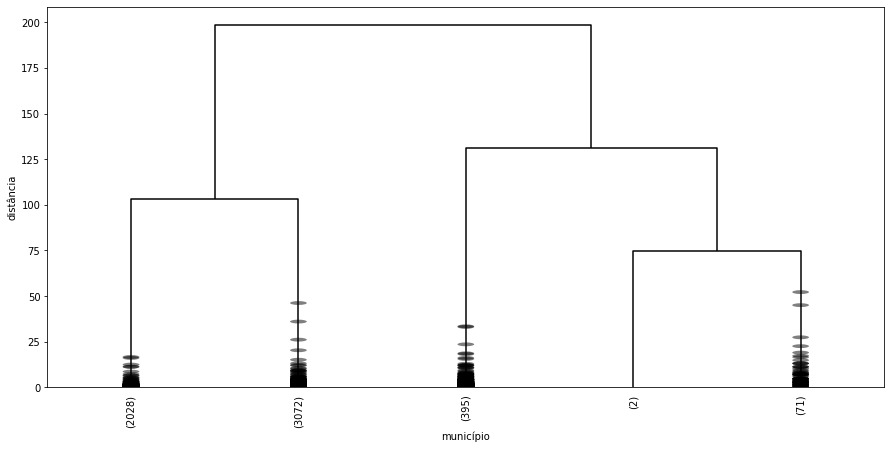

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

Método escolhido:

In [28]:
## definir a distância de corte baseando no dendrograma
max_d = 75
grupos = cut_tree(Z, height=max_d)

### Métricas

In [29]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

2832.14 0.98 0.39


In [30]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [31]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    3072
2    2028
1     395
3      73
Name: grupo, dtype: int64

In [32]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,,,
0,5.000651,1.134855e+06,6.259894e+04,2.653878e+04,3.548462e+04,1220.315781,105.482070,0.645508,-49.006754,-21.345361
1,83.207595,1.593592e+07,1.100353e+06,4.728250e+05,1.185301e+06,23764.627975,1309.090835,23.022785,-50.886619,-22.227118
2,0.644477,2.443410e+05,1.519207e+04,6.588274e+03,1.470408e+04,267.198654,15.648846,0.100099,-40.995768,-7.677835
3,302.630137,5.343104e+07,4.355295e+06,1.868618e+06,5.922764e+06,47785.720274,2346.097397,118.178082,-51.174294,-23.113622


In [33]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,,,
0,1.0,3.240435e+04,1407.325,632.555,0.00,0.00,0.02,0.0,-49.158700,-21.462332
1,70.0,1.316677e+07,948020.860,415065.920,891963.87,21649.66,1207.11,17.0,-51.612477,-23.474023
2,0.0,0.000000e+00,0.000,0.000,0.00,0.00,0.00,0.0,-39.752368,-7.294994
3,269.0,4.360530e+07,3644003.600,1584641.670,4787901.38,48788.24,2341.40,93.0,-51.409769,-23.400588


### As observações de cada grupo

In [34]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides

In [35]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

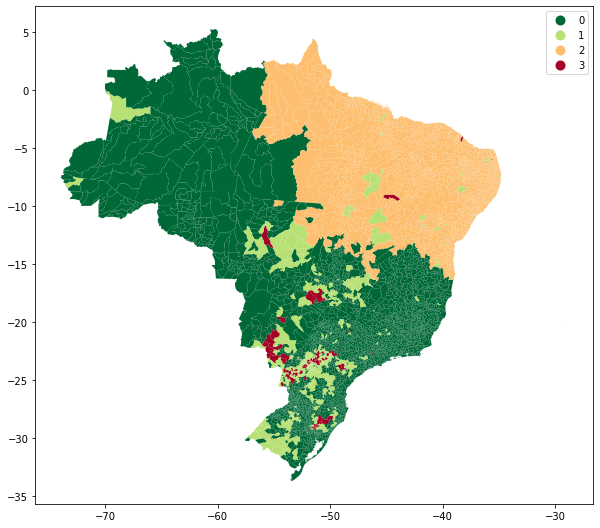

In [36]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

## K-Médias

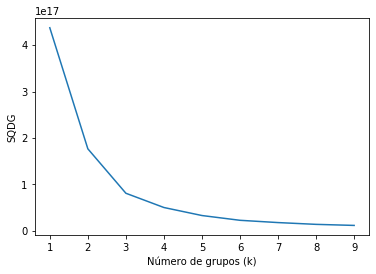

In [37]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [38]:
k = 4

In [39]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [40]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [41]:
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

3012.89 0.97 0.4


In [42]:
# contagens
dados_centroids.grupo.value_counts()

3    2863
1    2290
0     362
2      53
Name: grupo, dtype: int64

In [43]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,97.314917,1.683110e+07,1.206988e+06,5.222102e+05,1.414924e+06,26938.819613,1488.578619,29.574586,-50.891181,-22.511002,5.345304
1,0.660699,1.964333e+05,1.223789e+04,5.336931e+03,1.254431e+04,260.874197,14.425533,0.094323,-41.030085,-8.716563,0.156769
2,332.018868,6.481863e+07,5.255961e+06,2.244084e+06,6.815201e+06,48075.325472,2286.783585,125.849057,-51.128539,-22.934249,3.264151
3,6.039120,1.466599e+06,8.109295e+04,3.418270e+04,4.793908e+04,1491.033084,122.610307,0.808592,-49.749489,-21.755214,1.099895


In [44]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,79.5,1.408309e+07,1037887.03,440245.535,1073940.30,24988.37,1449.36,21.0,-51.537074,-23.468369,7
1,0.0,0.000000e+00,0.00,0.000,0.00,0.00,0.00,0.0,-40.341188,-7.704020,0
2,317.0,5.360152e+07,4280000.75,1846939.520,5502523.96,47141.37,1967.18,93.0,-51.552312,-23.514218,3
3,1.0,1.162648e+05,4605.47,2026.550,0.00,0.00,17.00,0.0,-49.584976,-21.877408,0


In [45]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroide K-médias

In [46]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

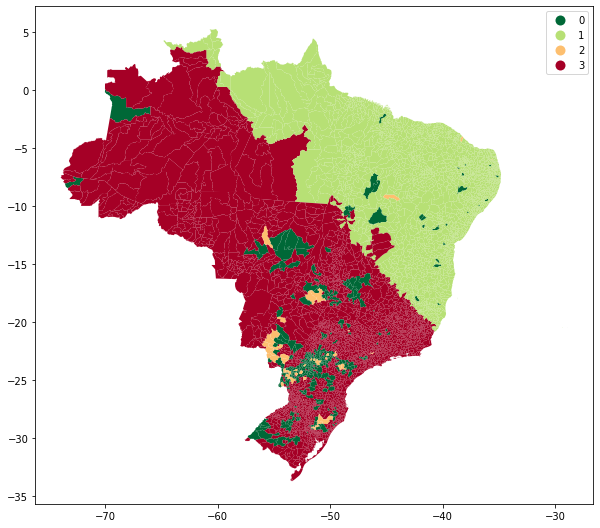

In [47]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

##  Spatially Constrained Hierarchical Clustering

In [48]:
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [49]:
model = AgglomerativeClustering(distance_threshold=80, linkage='ward', connectivity=w.sparse,  n_clusters=None)
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<5568x5568 sparse matrix of type '<class 'numpy.float64'>'
	with 28004 stored elements in Compressed Sparse Row format>,
                        distance_threshold=80, linkage='ward', memory=None,
                        n_clusters=None)

In [50]:
dados_centroids['grupo'] = model.labels_

In [51]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

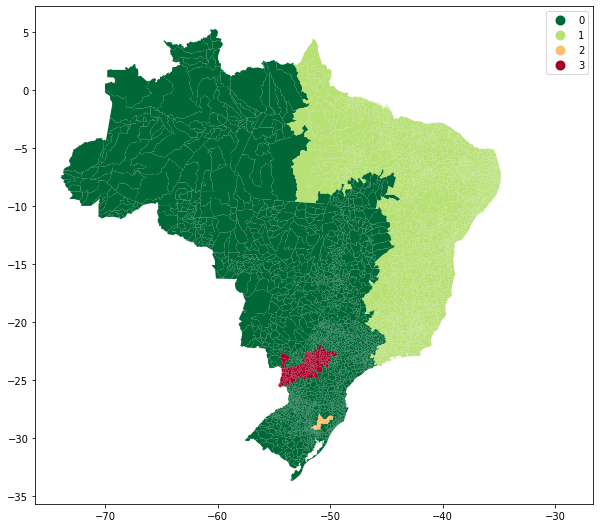

In [52]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

## Análise de agrupamento - Centroides - Outra distância

In [53]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [132]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=35, n_clusters=None, affinity='jaccard', linkage='average')

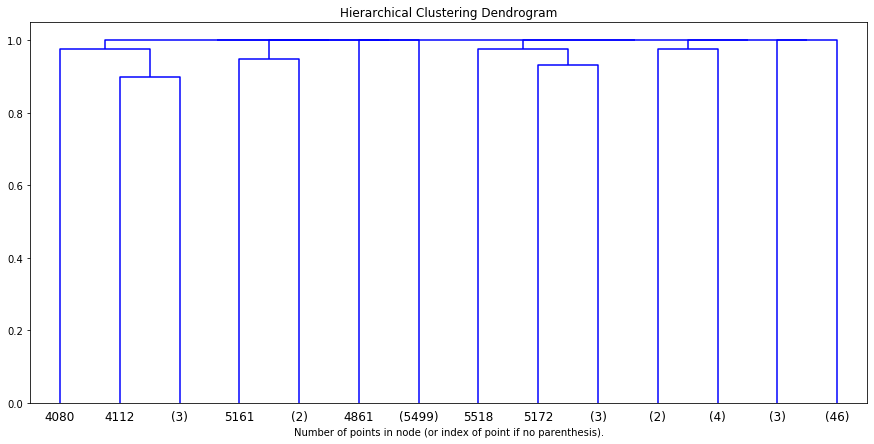

In [133]:
model = model.fit(X)
plt.subplots(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3, color_threshold=0.1)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Métricas

In [115]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, model.labels_),2),
  round(davies_bouldin_score(X, model.labels_),2),
  round(metrics.silhouette_score(X, model.labels_, metric='euclidean'),2)  
)

501.47 0.33 0.9


In [130]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = model.labels_
# moran_matrix.head(2)

In [131]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    5565
2       2
1       1
Name: grupo, dtype: int64

### Mapa Grupos Centroides

In [118]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

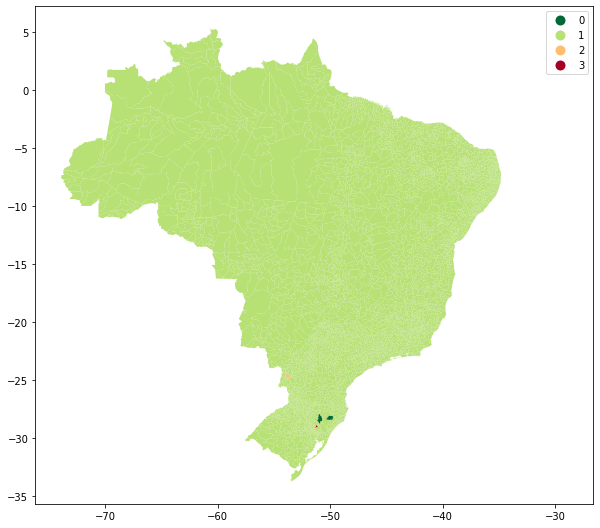

In [119]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'